In [40]:
import xgboost as xgb
import optuna
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [41]:
# Helper functions 

def metrics(y_true, y_pred):
    """Given two iterables of the same length, generate accuracy and precision metrics
    If its a binary classification for storage, plot a confusion matrix"""
    metrics = {}
    metrics["Accuracy"] = round(accuracy_score(y_true, y_pred), 3)
    metrics["Precision"] = round(precision_score(y_true, y_pred), 3)
    metrics["Recall"] = round(recall_score(y_true, y_pred), 3)
    metrics["F1 Score"] = round(f1_score(y_true, y_pred), 3)

    
    fig, ax = plt.subplots(figsize=(5, 4))
    g = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(y_true, y_pred),
        display_labels=["Not Fraud", "Fraud"],
    )
    g = g.plot(cmap=plt.cm.Blues, values_format="g", ax=ax)
    plt.show()
    return metrics

In [42]:
transactions = pd.read_parquet('joined_transactions.parquet')

In [43]:
transactions.columns

Index(['Card', 'Amount', 'Use Chip', 'Merchant State', 'MCC', 'Errors',
       'Current Age', 'Yearly Income - Person', 'FICO Score', 'DayOnlyTime',
       'Num Credit Cards', 'CurrentlyRetired', 'DebtIncomeRatio',
       'ZipIncomeRatio', 'Card Brand', 'Card Type', 'Has Chip', 'Cards Issued',
       'Credit Limit', 'MerchantCustomerStateMatch',
       'InternationalTransaction', 'Fraud'],
      dtype='object')

In [45]:
numeric_columns = [ 'Amount', 'Current Age', 'Yearly Income - Person', 'FICO Score',
                   'Num Credit Cards', 'DebtIncomeRatio',
                   'ZipIncomeRatio', 'Cards Issued', 'Credit Limit']

categorical_columns = ['Card', 'Use Chip', 'Merchant State', 'MCC', 'Errors', 
                       'CurrentlyRetired', 'Card Brand', 'Card Type', 'Has Chip', 'DayOnlyTime',
                       'MerchantCustomerStateMatch', 'InternationalTransaction', 'Fraud']

In [46]:
le = LabelEncoder()
for col in categorical_columns:
    transactions[col] = le.fit_transform(transactions[col])
    transactions[col] = transactions[col].astype("category")

In [47]:
# Split off testing dataset
X_other, X_test, y_other, y_test = train_test_split(transactions.drop(columns='Fraud'),
                                                    transactions['Fraud'],
                                                    test_size=.2, 
                                                    stratify=transactions['Fraud'],
                                                    random_state=42)

In [48]:
# Split off validation dataset
X_train, X_val, y_train, y_val = train_test_split(X_other,
                                                  y_other,
                                                  test_size=.2, 
                                                  stratify=y_other,
                                                  random_state=42)

In [49]:
!nvidia-smi

Mon Nov 13 22:42:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.01              Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Quadro P4000                   On  | 00000000:65:00.0  On |                  N/A |
| 48%   39C    P8              10W / 105W |   1086MiB /  8192MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
# Understand the undersampling
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=[0,1],
    indices=transactions['Fraud']
)

sample_weights

array([  0.50061228, 408.81104375])

In [79]:
def objective(trial):
    param = {
        "verbosity": 1,
        "enable_categorical":trial.suggest_categorical("enable_categorical", [True]),
        "objective": trial.suggest_categorical("objective", ["binary:logistic"]),
        "device": trial.suggest_categorical("device", ['cuda']),
        "n_estimators" : trial.suggest_int("n_estimators", 200, 500),
        "scale_pos_weight" : trial.suggest_categorical("scale_pos_weight", [30,80, 400]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # maximum depth of the tree, signifies complexity of the tree.
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight" : trial.suggest_int("min_child_weight", 2, 10),
        "eta" : trial.suggest_float("eta", 1e-8, 1.0, log=True),        
        #"tree_method":"hist"
    }
    
    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
              
    preds = model.predict(X_val)
    pred_labels = (preds > .5).astype(int)
    
    # Recall for fraud
    recall = recall_score(pred_labels, y_val)
    
    return recall

In [80]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2023-11-13 23:44:11,410] A new study created in memory with name: no-name-f849aa4a-c3c7-4e73-bc7f-a2b7a28d40fa
/home/swap/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

[I 2023-11-13 23:44:29,442] Trial 0 finished with value: 0.0 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 286, 'scale_pos_weight': 80, 'lambda': 5.4855793156996295e-05, 'alpha': 0.0010791214993351925, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.00011168094240516671}. Best is trial 0 with value: 0.0.
/home/swap/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.

[I 2023-11-13 23:45:00,103] Trial 1 finis

[I 2023-11-13 23:53:39,935] Trial 18 finished with value: 0.8619607843137255 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 430, 'scale_pos_weight': 30, 'lambda': 0.004848422548156239, 'alpha': 0.0033491044553340186, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.10746865684653151}. Best is trial 11 with value: 0.9.
[I 2023-11-13 23:54:15,215] Trial 19 finished with value: 0.6385269121813031 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 458, 'scale_pos_weight': 30, 'lambda': 0.07504835820866276, 'alpha': 0.08759916423156422, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.01056990349933552}. Best is trial 11 with value: 0.9.
/home/swap/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.



[I 2023-11-14 00:05:40,585] Trial 39 finished with value: 0.8511128165771297 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 356, 'scale_pos_weight': 80, 'lambda': 0.036555455944118305, 'alpha': 0.017869348572927636, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.33807255237223344}. Best is trial 11 with value: 0.9.
[I 2023-11-14 00:06:06,774] Trial 40 finished with value: 0.3961878829135466 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 280, 'scale_pos_weight': 80, 'lambda': 0.17106965065559052, 'alpha': 0.001803498471616099, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.01702430940245214}. Best is trial 11 with value: 0.9.
[I 2023-11-14 00:06:38,741] Trial 41 finished with value: 0.8894308943089431 and parameters: {'enable_categorical': True, 'objective': 'binary:logistic', 'device': 'cuda', 'n_estimators': 366, 'scale_pos_weight': 80, 'lambda': 0.03121215

In [81]:
best_params = study.best_params
best_params

{'enable_categorical': True,
 'objective': 'binary:logistic',
 'device': 'cuda',
 'n_estimators': 479,
 'scale_pos_weight': 30,
 'lambda': 0.6224268941182626,
 'alpha': 0.017567160437197013,
 'max_depth': 9,
 'min_child_weight': 10,
 'eta': 0.43304830341087985}

In [82]:
# Fit a model on the best parameters 
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)

# Check against the testing dataset
preds = model.predict(X_test)

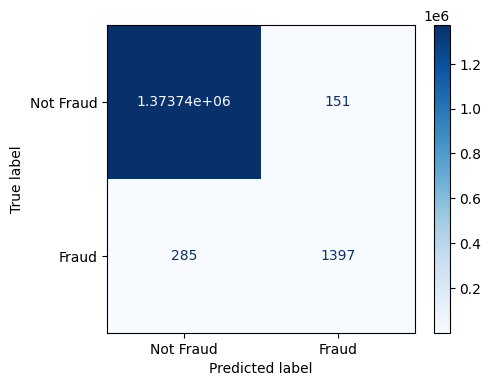

{'Accuracy': 1.0, 'Precision': 0.902, 'Recall': 0.831, 'F1 Score': 0.865}

In [83]:
# Look at the metrics
metrics(y_test, preds)

In [85]:
# Look at the feature importance
ax = xgb.plot_importance(model)
fig = ax.figure
fig.set_size_inches(10, 5)